In [1]:
import pandas as pd
import numpy as np
import json
from abi_json import *

In [2]:
INPUT_FILE = 'andmed/toorandmed_aasta.csv'
df = pd.read_csv(INPUT_FILE, low_memory=False)
enne = len(df)
enne

3156

In [3]:
df = df[df['additional_info__duration_in_semesters'] <= 1] # eemaldada ained, mille kestus on rohkem kui 1 semester
df = df[df['additional_info__assessment_scale__code'] != 'defence'] # eemaldada kaitsmise ained
elfilter = len(df)
elfilter

3154

eristav/mitteeristav - **additional_info__assessment_scale__et** asemel `additional_info__assessment_scale__code` <br>
kevad/sügis - `version__target__semester__et` <br>
õppeaste (baka/magister jne) - `version__additional_info__study_levels` JSON <br>
keel (võib ka esialgu mitte teha, oma valik) - `version__overview__study_languages` JSON <br>
asukoht (võib ka esialgu mitte teha, oma valik) - `version__target__course_main_structural_unit__city` 1168 on tühjad<br>
hindamisest lugeda välja, kas eksam toimub (suht nišš, võib mitte teha) - `version__grading__grade_evaluation__et`


In [4]:
def resolve_fields(df):
    """
    Loob uued puhtad veerud, eelistades versiooni-põhist infot.
    Tagastab täiendatud DataFrame'i.
    """

    # 1. Veerud, kus ühendame üldise info ja versiooni info (eelistades versiooni)
    # (uus nimi, üldise info veerg, versiooni info veerg)
    merge_mapping = [
        ('nimi_et', 'title__et', 'version__title__et'),
        ('nimi_en', 'title__en', 'version__title__en'),
        ('eap', 'credits', 'version__credits'),
        ('kirjeldus', 'overview__description__et', 'version__overview__description__et')
    ]

    # 2. Veerud, mis võetakse ühest konkreetsest kohast (lihtne ümbernimetamine)
    # (uus nimi, vana nimi)
    rename_mapping = [
        ('aine_kood', 'code'),
        ('eeldusained', 'additional_info__prerequisites'), # 2588 puudu. JSON
        ('keel', 'version__overview__study_languages'), # 21 puudu. JSON
        ('semester', 'version__target__semester__et'), # 20 puudu
        ('oppeaste', 'version__additional_info__study_levels'), # 59 puudu. JSON
        ('asukot', 'version__target__course_main_structural_unit__city'), # 1168 puudu
        ('Eristamata/eristuv', 'additional_info__assessment_scale__code'),
        ('hinne_kujunemine', 'version__grading__grade_evaluation__et') # str
    ]

    for new_col, base, version in merge_mapping:
        base_exists = base in df.columns if base else False
        ver_exists = version in df.columns if version else False
        
        if base_exists and ver_exists:
            df[new_col] = df[version].fillna(df[base])
        elif ver_exists:
            df[new_col] = df[version]
        elif base_exists:
            df[new_col] = df[base]
        else:
            df[new_col] = np.nan
    for new_col, source in rename_mapping:
        if source in df.columns:
            df[new_col] = df[source]
        else:
            df[new_col] = np.nan
    return df

uued_nimed = [
    'nimi_et', 'nimi_en', 'eap', 'kirjeldus', 
    'aine_kood', 'eeldusained', 'keel', 'semester', 
    'oppeaste', 'asukot', 'Eristamata/eristuv', 'hinne_kujunemine'
]

# Rakendame funktsiooni
df_resolved = resolve_fields(df.copy())
df_final = df_resolved[uued_nimed]

In [5]:
df_final.head(2)

,nimi_et,nimi_en,eap,kirjeldus,aine_kood,eeldusained,keel,semester,oppeaste,asukot,Eristamata/eristuv,hinne_kujunemine
0,Rahvusvaheline eraõigus,Private International Law,6.0,Kursuse raames käsitletakse rahvusvahelise era...,OIEO.06.046,NaN,"[{""code"": ""et"", ""en"": ""Estonian"", ""et"": ""eesti...",kevad,"[{""code"": ""master"", ""en"": ""master's studies"", ...",Tartu linn,grade,100% kirjalik eksam.
1,Praktiseerimine töökeskkonnas,Practice in the Work Environment,3.0,Aines Praktiseerimine töökeskkonnas laiendab ü...,KKSB.05.092,NaN,"[{""code"": ""et"", ""en"": ""Estonian"", ""et"": ""eesti...",kevad,"[{""code"": ""bachelor"", ""en"": ""bachelor's studie...",Tartu linn,pass,NaN


In [6]:
for tulp in uued_nimed:
    print(tulp, len(df_final[tulp].unique()))


nimi_et 2754
nimi_en 2775
eap 29
kirjeldus 2885
aine_kood 2981
eeldusained 459
keel 58
semester 3
oppeaste 24
asukot 8
Eristamata/eristuv 2
hinne_kujunemine 2539


In [7]:
# JSONi puhastamise kood on failis abi_json.py

df_final['eeldusained_clean'] = df_final['eeldusained'].apply(extract_eeldusained)
df_final['keel_clean'] = df_final['keel'].apply(extract_keel)
df_final['oppeaste_clean'] = df_final['oppeaste'].apply(extract_oppeaste)
df_final = df_final.drop(columns=['eeldusained', 'keel', 'oppeaste'])
df_final.head(3)

/var/folders/98/n8zvccd94f1ck8hwmpv399f40000gn/T/ipykernel_6137/814241353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['eeldusained_clean'] = df_final['eeldusained'].apply(extract_eeldusained)
/var/folders/98/n8zvccd94f1ck8hwmpv399f40000gn/T/ipykernel_6137/814241353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['keel_clean'] = df_final['keel'].apply(extract_keel)
/var/folders/98/n8zvccd94f1ck8hwmpv399f40000gn/T/ipykernel_6137/814241353.py:5: SettingWithCopyWarning: 
A value is

,nimi_et,nimi_en,eap,kirjeldus,aine_kood,semester,asukot,Eristamata/eristuv,hinne_kujunemine,eeldusained_clean,keel_clean,oppeaste_clean
0,Rahvusvaheline eraõigus,Private International Law,6.00,Kursuse raames käsitletakse rahvusvahelise era...,OIEO.06.046,kevad,Tartu linn,grade,100% kirjalik eksam.,None,eesti keel,magistriõpe
1,Praktiseerimine töökeskkonnas,Practice in the Work Environment,3.00,Aines Praktiseerimine töökeskkonnas laiendab ü...,KKSB.05.092,kevad,Tartu linn,pass,NaN,None,eesti keel,bakalaureuseõpe
2,Lastekirurgia,Paediatric Surgery,2.25,Lastekirurgiliste haiguste diagnoosimise ja ra...,ARKI.02.030,sügis,Tartu linn,pass,"A part of the complec exam ""Surgery""",AR00.00.016,inglise keel,integreeritud bakalaureuse- ja magistriõpe


In [8]:
#
#
#
# Puuduvate väärtuste hulk igas veerus.
df_final.isna().sum()


nimi_et                  0
nimi_en                  0
eap                      0
kirjeldus                0
aine_kood                0
semester                20
asukot                1168
Eristamata/eristuv       0
hinne_kujunemine       389
eeldusained_clean     2588
keel_clean              21
oppeaste_clean          59
dtype: int64

In [9]:
#
#
#
# Kategooriliste tunnustega veergude [keel, semester, õppeaste, …] enim levinud väärtused (näiteks df[tunnus].count().head(5))

categorical_cols = ['semester', 'asukot', 'Eristamata/eristuv', 'keel_clean', 'oppeaste_clean']

for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df_final[col].value_counts().head(5))



--- semester ---
semester
kevad    1569
sügis    1565
Name: count, dtype: int64

--- asukot ---
asukot
Tartu linn         1689
Narva linn          128
Viljandi linn       119
Pärnu linn           34
Tõravere alevik      11
Name: count, dtype: int64

--- Eristamata/eristuv ---
Eristamata/eristuv
grade    1863
pass     1291
Name: count, dtype: int64

--- keel_clean ---
keel_clean
eesti keel                  1985
inglise keel                 771
eesti keel, inglise keel     168
vene keel                     48
saksa keel                    19
Name: count, dtype: int64

--- oppeaste_clean ---
oppeaste_clean
bakalaureuseõpe                               969
magistriõpe                                   576
bakalaureuseõpe, magistriõpe                  320
integreeritud bakalaureuse- ja magistriõpe    260
bakalaureuseõpe, doktoriõpe, magistriõpe      217
Name: count, dtype: int64


In [10]:
#
#
#
# "Sissejuhatus andmeteadusesse” aine kogu puhastatud kujul väljund lihtsasti loetaval kujul
course = df_final[df_final['nimi_et'] == "Sissejuhatus andmeteadusesse"].iloc[0]

print(f"""
📘 AINEINFO
----------------------------------------
Nimi (ET): {course['nimi_et']}
Nimi (EN): {course['nimi_en']}
Ainekood: {course['aine_kood']}
EAP: {course['eap']}

📅 Semester: {course['semester']}
🎓 Õppeaste: {course['oppeaste_clean']}
🌍 Õppekeel: {course['keel_clean']}
📍 Asukoht: {course['asukot']}
📝 Hindamisviis: {course['Eristamata/eristuv']}

📚 Eeldusained: {course['eeldusained_clean'] if pd.notna(course['eeldusained_clean']) else "Puuduvad"}

📖 Hindamise kujunemine:
{course['hinne_kujunemine'] if pd.notna(course['hinne_kujunemine']) else "Info puudub"}

📄 Kirjeldus:
{course['kirjeldus']}
----------------------------------------
""")



📘 AINEINFO
----------------------------------------
Nimi (ET): Sissejuhatus andmeteadusesse
Nimi (EN): Introduction to Data Science
Ainekood: LTAT.02.002
EAP: 6.0

📅 Semester: sügis
🎓 Õppeaste: bakalaureuseõpe, magistriõpe
🌍 Õppekeel: inglise keel
📍 Asukoht: nan
📝 Hindamisviis: grade

📚 Eeldusained: Puuduvad

📖 Hindamise kujunemine:
See the grading and requirements information at the course web page https://courses.cs.ut.ee/2024/ids/fall/

📄 Kirjeldus:
Kursus annab lühiülevaate andmeteaduse põhimõistetest, põhiprintsiipidest ning praktilistest aspektidest. Lõppeesmärk on õppida planeerima ning läbi viima lihtsat praktilist andmeteaduse projekti. Kursus käsitleb peamisi andmete kirjeldava analüüsi ning visualiseerimise meetodeid, sagedaste mustrite otsimist, klasteranalüüsi, peakomponentanalüüsi, peamisi masinõppemeetodeid klassifitseerimise ja regressiooni jaoks (sealhulgas sügavaid neurovõrke), andmete haldamist ning statistiliste testide interpreteerimist. Tutvutakse andmeteaduse pr

In [11]:
#
#
#
# Lisada tunnus kirjeldus, sisaldab ühe aine koguinfot (kõik veerud ühendatud suureks tekstiks

# Asendame NaN tühja stringiga
df_temp = df_final.fillna("")

# Ühendame kõik veerud üheks tekstiks
df_final["kirjeldus_full"] = df_temp.astype(str).agg(" | ".join, axis=1)

# Teha tunnuse kirjeldus tähemärkide arvu statistika 
df_final["kirjeldus_pikkus"] = df_final["kirjeldus_full"].str.len()


In [12]:
df_final["kirjeldus_pikkus"].describe()


count    3154.000000
mean      795.316107
std       436.808627
min        81.000000
25%       494.000000
50%       701.000000
75%       966.000000
max      3677.000000
Name: kirjeldus_pikkus, dtype: float64

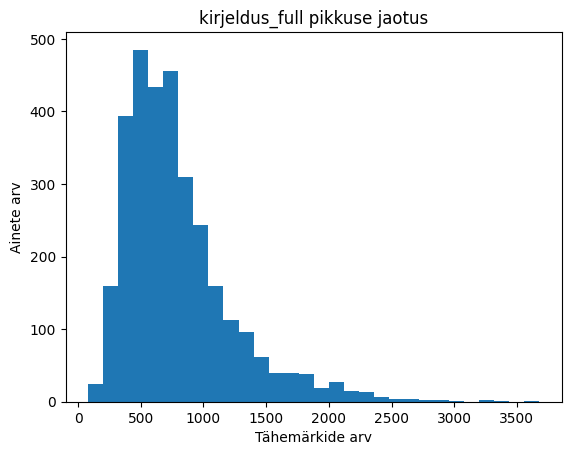

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_final["kirjeldus_pikkus"], bins=30)
plt.xlabel("Tähemärkide arv")
plt.ylabel("Ainete arv")
plt.title("kirjeldus_full pikkuse jaotus")
plt.show()
